Using device: cuda:0



--- Running Configuration: MLP NoNorm ---
Using fixed val batch of size 512 for rank eval.
Logging ranks for Epoch 0 (Initialization) for MLP NoNorm...
Epoch 0 [MLP NoNorm] Ranks: Input:34.7 | H1_Linear:35.4 | H1_Tanh:38.5 | H2_Linear:35.2 | H2_Tanh:35.1 ...


Epoch 1 [MLP NoNorm] Ranks: Input:34.7 | H1_Linear:8.3 | H1_Tanh:26.9 | H2_Linear:21.9 | H2_Tanh:23.3 ...


Epoch 2 [MLP NoNorm] Ranks: Input:34.7 | H1_Linear:8.7 | H1_Tanh:29.3 | H2_Linear:21.2 | H2_Tanh:23.7 ...


Epoch 3 [MLP NoNorm] Ranks: Input:34.7 | H1_Linear:9.5 | H1_Tanh:32.1 | H2_Linear:20.4 | H2_Tanh:23.6 ...


Epoch 4 [MLP NoNorm] Ranks: Input:34.7 | H1_Linear:10.1 | H1_Tanh:34.3 | H2_Linear:20.7 | H2_Tanh:25.1 ...


Epoch 5 [MLP NoNorm] Ranks: Input:34.7 | H1_Linear:10.9 | H1_Tanh:37.1 | H2_Linear:20.6 | H2_Tanh:26.1 ...
Finished training for MLP NoNorm

--- Running Configuration: MLP BatchNorm ---
Using fixed val batch of size 512 for rank eval.
Logging ranks for Epoch 0 (Initialization) for MLP BatchNorm...
Epoch 0 [MLP BatchNorm] Ranks: Input:34.7 | H1_Linear:33.5 | H1_BatchNorm:33.5 | H1_Tanh:36.9 | H2_Linear:37.1 ...


Epoch 1 [MLP BatchNorm] Ranks: Input:34.7 | H1_Linear:9.6 | H1_BatchNorm:9.6 | H1_Tanh:12.2 | H2_Linear:11.5 ...


Epoch 2 [MLP BatchNorm] Ranks: Input:34.7 | H1_Linear:11.8 | H1_BatchNorm:11.8 | H1_Tanh:15.4 | H2_Linear:13.1 ...


Epoch 3 [MLP BatchNorm] Ranks: Input:34.7 | H1_Linear:14.4 | H1_BatchNorm:14.4 | H1_Tanh:19.1 | H2_Linear:14.7 ...


Epoch 4 [MLP BatchNorm] Ranks: Input:34.7 | H1_Linear:15.7 | H1_BatchNorm:15.7 | H1_Tanh:21.0 | H2_Linear:15.6 ...


Epoch 5 [MLP BatchNorm] Ranks: Input:34.7 | H1_Linear:18.0 | H1_BatchNorm:18.0 | H1_Tanh:24.5 | H2_Linear:17.3 ...
Finished training for MLP BatchNorm

--- Running Configuration: MLP LayerNorm ---
Using fixed val batch of size 512 for rank eval.
Logging ranks for Epoch 0 (Initialization) for MLP LayerNorm...
Epoch 0 [MLP LayerNorm] Ranks: Input:34.7 | H1_Linear:36.7 | H1_LayerNorm:42.6 | H1_Tanh:45.8 | H2_Linear:43.3 ...


Epoch 1 [MLP LayerNorm] Ranks: Input:34.7 | H1_Linear:12.9 | H1_LayerNorm:14.2 | H1_Tanh:17.3 | H2_Linear:14.3 ...


Epoch 2 [MLP LayerNorm] Ranks: Input:34.7 | H1_Linear:15.9 | H1_LayerNorm:17.0 | H1_Tanh:21.1 | H2_Linear:16.1 ...


Epoch 3 [MLP LayerNorm] Ranks: Input:34.7 | H1_Linear:19.0 | H1_LayerNorm:19.9 | H1_Tanh:25.1 | H2_Linear:17.9 ...


Epoch 4 [MLP LayerNorm] Ranks: Input:34.7 | H1_Linear:21.6 | H1_LayerNorm:22.5 | H1_Tanh:28.7 | H2_Linear:19.8 ...


Epoch 5 [MLP LayerNorm] Ranks: Input:34.7 | H1_Linear:23.0 | H1_LayerNorm:24.1 | H1_Tanh:30.8 | H2_Linear:21.1 ...
Finished training for MLP LayerNorm


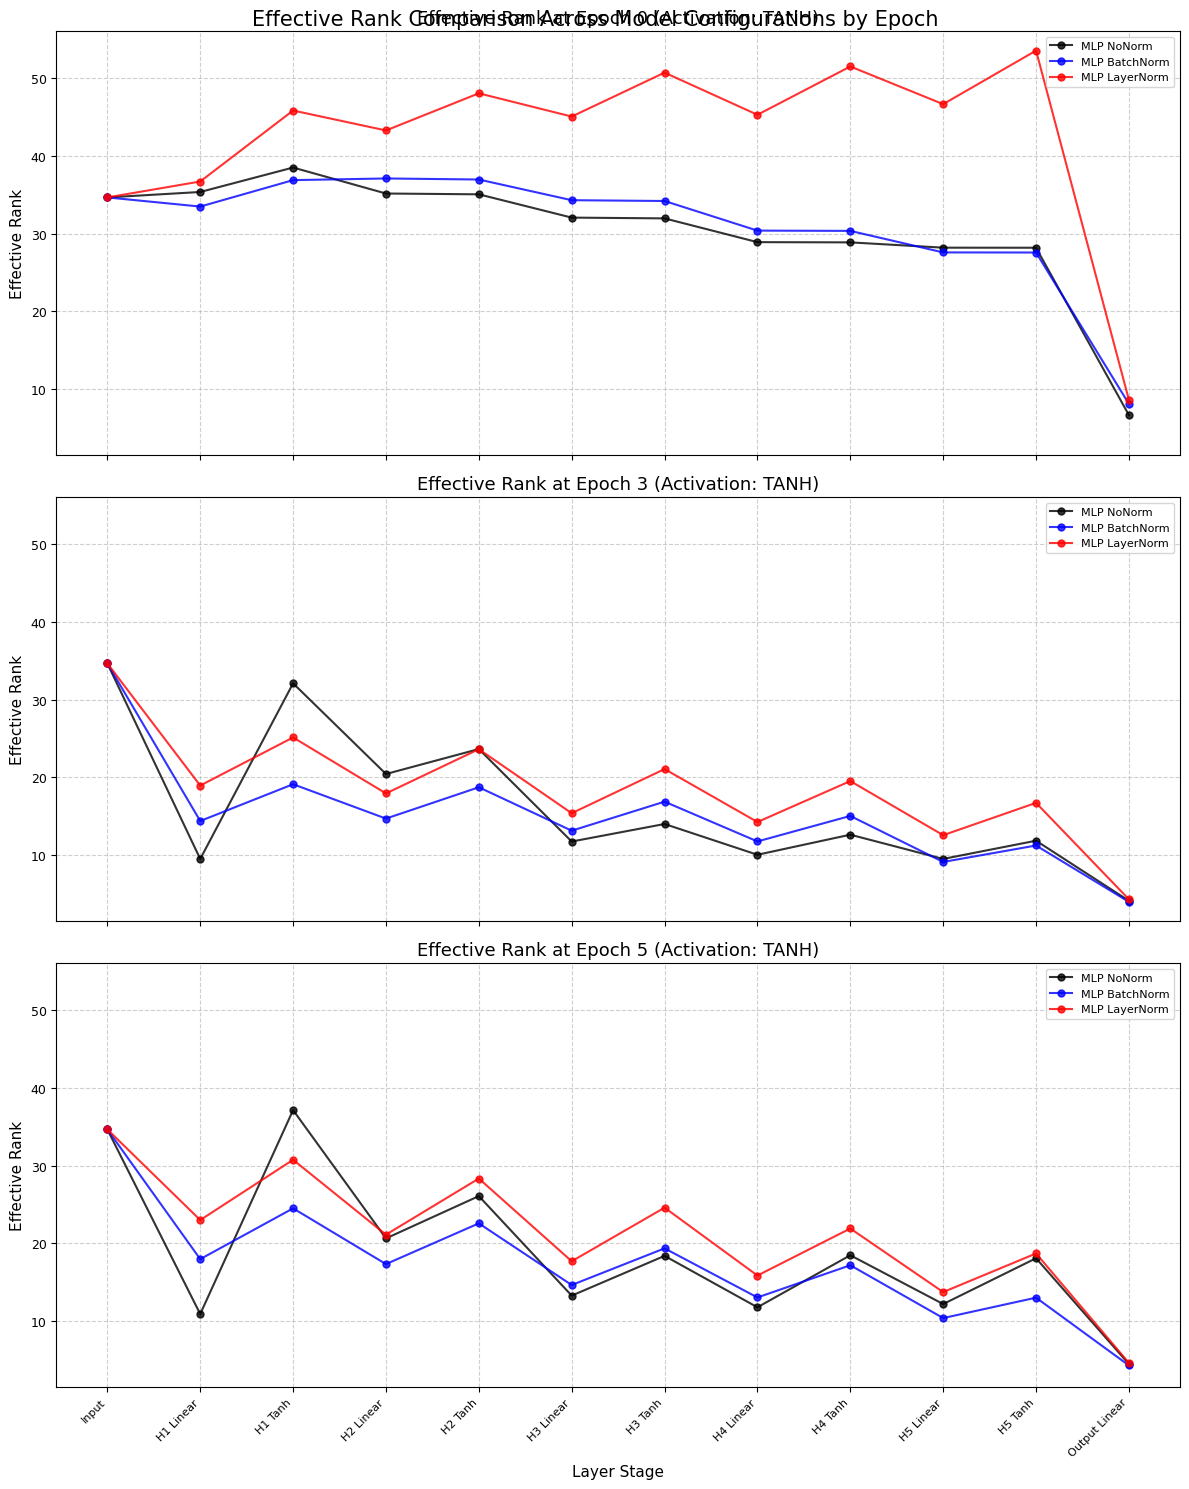

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D # For custom legends if needed later
from tqdm import tqdm

# --- Matplotlib Styling (Optional) ---
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 13, # Slightly smaller for subplots
    'axes.labelsize': 11,
    'xtick.labelsize': 8, # Smaller for potentially many layer names
    'ytick.labelsize': 9,
    'legend.fontsize': 8,
    'figure.titlesize': 15, # Main figure title
    'lines.linewidth': 1.5,
    'lines.markersize': 4
})

# --- 1. Helper Functions ---

def compute_effective_rank(activations_batch):
    if activations_batch.ndim == 1:
        if activations_batch.shape[0] > 1: return 1.0
        else: activations_batch = activations_batch.unsqueeze(0)
    if activations_batch.shape[1] == 0: return 0.0
    if activations_batch.shape[1] == 1: return 1.0
    if activations_batch.shape[0] <= 1: return 1.0

    std_devs = torch.std(activations_batch, dim=0)
    valid_features_mask = std_devs > 1e-5
    if valid_features_mask.sum() < 2: return float(valid_features_mask.sum().item())
    activations_batch_filtered = activations_batch[:, valid_features_mask]

    try:
        if activations_batch_filtered.shape[0] <= 1 or activations_batch_filtered.shape[1] < 2:
            return float(activations_batch_filtered.shape[1] > 0)
        corr_matrix = torch.corrcoef(activations_batch_filtered.T)
    except RuntimeError: return 1.0
    if torch.isnan(corr_matrix).any(): corr_matrix = torch.nan_to_num(corr_matrix, nan=0.0)

    s_unnormalized = torch.linalg.svdvals(corr_matrix)
    sum_s = torch.sum(s_unnormalized)
    if sum_s < 1e-12: return 0.0
    s_norm_for_entropy = s_unnormalized / sum_s
    s_norm_for_entropy = s_norm_for_entropy[s_norm_for_entropy > 1e-15]
    if len(s_norm_for_entropy) == 0: return 0.0
    entropy = -torch.sum(s_norm_for_entropy * torch.log(s_norm_for_entropy))
    return torch.exp(entropy).item()

def get_activation_fn_and_name(activation_name_str):
    name = activation_name_str.lower()
    if name == "relu": return nn.ReLU(), "ReLU"
    elif name == "tanh": return nn.Tanh(), "Tanh"
    elif name == "sigmoid": return nn.Sigmoid(), "Sigmoid"
    elif name == "gelu": return nn.GELU(), "GELU"
    elif name == "identity": return nn.Identity(), "Identity"
    else: raise ValueError(f"Unsupported activation: {activation_name_str}")

# --- 2. Model Definition ---
class MLPBlock(nn.Module):
    def __init__(self, in_dim, out_dim, norm_type, activation_fn_instance, dropout_p, is_output_layer_block, block_idx):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.norm = None
        self.act_fn_instance = activation_fn_instance # Store for naming
        self.norm_type_str = norm_type # Store for naming
        self.is_output_layer_block = is_output_layer_block
        self.block_idx = block_idx # e.g., 0 for H1, 1 for H2...

        layer_prefix = f"H{block_idx + 1}" if not is_output_layer_block else "Output"
        self.layer_names = {"linear": f"{layer_prefix}_Linear"}


        if not is_output_layer_block and norm_type:
            if norm_type.lower() == "batchnorm":
                self.norm = nn.BatchNorm1d(out_dim)
                self.layer_names["norm"] = f"{layer_prefix}_BatchNorm"
            elif norm_type.lower() == "layernorm":
                self.norm = nn.LayerNorm(out_dim)
                self.layer_names["norm"] = f"{layer_prefix}_LayerNorm"
            elif norm_type.lower() != "none":
                raise ValueError(f"Unsupported norm_type: {norm_type}")
        
        if not is_output_layer_block:
            self.act = activation_fn_instance
            act_name = self.act.__class__.__name__ if not isinstance(self.act, nn.modules.activation.Tanh) else "Tanh" # Tanh doesn't have a clean name sometimes
            if isinstance(self.act, nn.Identity): act_name = "Identity" # Handle explicit Identity
            self.layer_names["act"] = f"{layer_prefix}_{act_name}"
        else:
            self.act = nn.Identity() # Output layer has no activation for logits

        self.dropout = nn.Dropout(dropout_p) if not is_output_layer_block and dropout_p > 0 else nn.Identity()

    def forward(self, x, record_activations_in_block=False):
        recorded_stages_in_block = [] # List of (name, tensor)

        x_linear = self.linear(x)
        if record_activations_in_block:
            recorded_stages_in_block.append((self.layer_names["linear"], x_linear.detach().cpu()))
        
        current_x = x_linear
        if not self.is_output_layer_block:
            if self.norm:
                current_x = self.norm(current_x)
                if record_activations_in_block:
                    recorded_stages_in_block.append((self.layer_names["norm"], current_x.detach().cpu()))
            
            current_x = self.act(current_x)
            if record_activations_in_block:
                recorded_stages_in_block.append((self.layer_names["act"], current_x.detach().cpu()))
            
            output_for_next_layer = self.dropout(current_x)
        else: # Output layer block
            output_for_next_layer = current_x # This is the logits

        if record_activations_in_block:
            return output_for_next_layer, recorded_stages_in_block
        else:
            return output_for_next_layer, []


class ConfigurableMLP(nn.Module):
    def __init__(self, layer_dims, activation_name="relu", norm_type=None, dropout_p=0.0):
        super().__init__()
        self.layer_dims = layer_dims
        self.input_dim = layer_dims[0]
        self.activation_name_str = activation_name # Store for reference
        self.norm_type_str = norm_type
        
        act_fn_instance, _ = get_activation_fn_and_name(activation_name)
        self.layer_stage_names = ["Input"] # Start with input

        self.blocks = nn.ModuleList()
        for i in range(len(layer_dims) - 1):
            is_final_block = (i == len(layer_dims) - 2)
            block = MLPBlock(
                layer_dims[i], layer_dims[i+1],
                norm_type, act_fn_instance, dropout_p,
                is_output_layer_block=is_final_block,
                block_idx=i 
            )
            self.blocks.append(block)
            # Collect layer names from the block
            self.layer_stage_names.append(block.layer_names["linear"])
            if "norm" in block.layer_names:
                self.layer_stage_names.append(block.layer_names["norm"])
            if "act" in block.layer_names: # "act" only if not output block
                 self.layer_stage_names.append(block.layer_names["act"])
            
    def forward(self, x, record_activations=False):
        x_flattened = x.view(x.size(0), -1)
        if x_flattened.shape[1] != self.input_dim:
            raise ValueError(f"Input dim mismatch: {x_flattened.shape[1]} vs {self.input_dim}")

        all_recorded_stages = [] # List of (name, tensor)
        current_features = x_flattened
        
        if record_activations:
            all_recorded_stages.append(("Input", current_features.detach().cpu()))

        for block in self.blocks:
            current_features, block_recorded_activations = block(current_features, record_activations_in_block=record_activations)
            if record_activations:
                all_recorded_stages.extend(block_recorded_activations)
        
        final_model_output = current_features

        if record_activations:
            return final_model_output, all_recorded_stages
        return final_model_output

# --- 3. Data Handling ---
def get_cifar10_dataloaders(batch_size=128, num_workers=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    try:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # Changed path
    except Exception as e: print(f"Error training set: {e}"); raise
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=torch.cuda.is_available())
    try:
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) # Changed path
    except Exception as e: print(f"Error test set: {e}"); raise
    testloader = DataLoader(testset, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())
    return trainloader, testloader

# --- 4. Training and Evaluation Loop with Rank Logging ---
def _log_ranks_for_epoch(model, fixed_val_images, epoch_num, model_config_name, all_rank_data_list):
    model.eval()
    with torch.no_grad():
        _, recorded_stages = model(fixed_val_images, record_activations=True)
        current_epoch_ranks_info = []
        for stage_name, acts_batch in recorded_stages:
            eff_rank = np.nan
            if acts_batch.size(0) > 1 and acts_batch.ndim > 1 and acts_batch.shape[1] > 0:
                eff_rank = compute_effective_rank(acts_batch)
            
            all_rank_data_list.append({
                'model_config': model_config_name, 'epoch': epoch_num,
                'layer_name': stage_name, 'eff_rank': eff_rank
            })
            current_epoch_ranks_info.append(f"{stage_name}:{eff_rank:.1f}" if not np.isnan(eff_rank) else f"{stage_name}:NaN")
    
    print(f"Epoch {epoch_num} [{model_config_name}] Ranks: {' | '.join(current_epoch_ranks_info[:5])} ...") # Print first few
    model.train()


def train_model_with_rank_logging(
    model_config_name, model, train_loader, val_loader, 
    optimizer, criterion, num_epochs, device, 
    log_rank_every_n_epochs=1, rank_eval_batch_size=256
    ):
    
    all_rank_data = [] 
    fixed_val_images = None 
    try: # Prepare fixed validation batch
        fixed_val_images_list = []
        num_batches_for_rank = 1
        if val_loader.batch_size and val_loader.batch_size > 0 :
            num_batches_for_rank = max(1, rank_eval_batch_size // val_loader.batch_size)
        elif rank_eval_batch_size > 0 :
             print(f"Warning: val_loader.batch_size is None/0. Will fetch {rank_eval_batch_size} samples.")
        else: raise ValueError("val_loader.batch_size is None/0, and rank_eval_batch_size not positive.")

        val_iter_for_rank = iter(val_loader)
        current_fetched_samples = 0
        while current_fetched_samples < rank_eval_batch_size:
            try:
                imgs, _ = next(val_iter_for_rank)
                fixed_val_images_list.append(imgs)
                current_fetched_samples += imgs.size(0)
            except StopIteration: print("Warning: Val loader exhausted for rank batch."); break
        if not fixed_val_images_list: raise ValueError("Val loader empty/too small for rank batch.")
        fixed_val_images_cat = torch.cat(fixed_val_images_list, dim=0)
        if fixed_val_images_cat.size(0) > rank_eval_batch_size:
            fixed_val_images_cat = fixed_val_images_cat[:rank_eval_batch_size]
        if fixed_val_images_cat.size(0) == 0: raise ValueError("No images for fixed_val_images.")
        fixed_val_images = fixed_val_images_cat.to(device)
        print(f"Using fixed val batch of size {fixed_val_images.shape[0]} for rank eval.")
    except Exception as e:
        print(f"Could not prepare fixed val batch: {e}. Falling back to train batch.")
        try:
            fb_imgs, _ = next(iter(train_loader)) 
            if fb_imgs.size(0) > rank_eval_batch_size: fb_imgs = fb_imgs[:rank_eval_batch_size]
            fixed_val_images = fb_imgs.to(device)
        except Exception as fallback_e: print(f"Fallback failed: {fallback_e}. No rank logging."); return pd.DataFrame(all_rank_data)

    # --- Log Ranks at Epoch 0 (Initialization) ---
    if fixed_val_images is not None and fixed_val_images.nelement() > 0:
        print(f"Logging ranks for Epoch 0 (Initialization) for {model_config_name}...")
        _log_ranks_for_epoch(model, fixed_val_images, 0, model_config_name, all_rank_data)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
                            desc=f"Epoch {epoch+1}/{num_epochs} [{model_config_name}]", leave=False)
        for i, data in progress_bar:
            inputs, labels = data; inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            running_loss += loss.item()
            if (i + 1) % 100 == 0: progress_bar.set_postfix({'loss': f'{running_loss / 100:.3f}'}); running_loss = 0.0
        
        if (epoch + 1) % log_rank_every_n_epochs == 0 and fixed_val_images is not None and fixed_val_images.nelement() > 0:
            _log_ranks_for_epoch(model, fixed_val_images, epoch + 1, model_config_name, all_rank_data)

    print(f"Finished training for {model_config_name}")
    return pd.DataFrame(all_rank_data)

# --- 5. Main Experiment Orchestration ---
def run_main_experiment(
    num_epochs=10, log_rank_every_n_epochs=1, mlp_hidden_layers=[256, 128], 
    activation_name="relu", dropout_p=0.1, learning_rate=1e-3,
    batch_size=256, rank_eval_batch_size_config=512
    ):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); print(f"Using device: {device}")
    try: train_loader, val_loader = get_cifar10_dataloaders(batch_size=batch_size)
    except Exception as e: print(f"Failed to load CIFAR-10: {e}. Aborting."); return

    input_dim = 32 * 32 * 3; num_classes = 10
    layer_dims_template = [input_dim] + mlp_hidden_layers + [num_classes]

    configurations = {
        "MLP NoNorm": {"norm_type": None},
        "MLP BatchNorm": {"norm_type": "batchnorm"},
        "MLP LayerNorm": {"norm_type": "layernorm"}
    }
    all_experimental_rank_data = []
    # To get consistent layer stage names for plotting x-axis later
    sample_model_for_layer_names = ConfigurableMLP(layer_dims_template, activation_name, None, 0.0)
    plot_layer_stage_names = sample_model_for_layer_names.layer_stage_names
    del sample_model_for_layer_names


    for config_name, params in configurations.items():
        print(f"\n--- Running Configuration: {config_name} ---")
        model = ConfigurableMLP(layer_dims_template, activation_name, params["norm_type"], dropout_p).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate); criterion = nn.CrossEntropyLoss()
        rank_data_df = train_model_with_rank_logging(
            config_name, model, train_loader, val_loader, optimizer, criterion, 
            num_epochs, device, log_rank_every_n_epochs, rank_eval_batch_size_config
        )
        all_experimental_rank_data.append(rank_data_df)
        del model; 
        if torch.cuda.is_available(): torch.cuda.empty_cache()

    if not all_experimental_rank_data or all(df.empty for df in all_experimental_rank_data):
        print("No rank data. Exiting plot."); return
    final_rank_df = pd.concat(all_experimental_rank_data, ignore_index=True)

    # --- 6. Visualization ---
    # MODIFIED: Reversing the role of epochs and model configurations
    if final_rank_df.empty: 
        print("Final rank df empty. Skipping plot.")
        return
        
    # Get unique epochs and select a subset (initial, middle, final)
    unique_epochs = sorted(final_rank_df['epoch'].dropna().unique())
    if not unique_epochs: 
        print("No epochs in data. Skipping plot.")
        return
    
    # Select only 3 epochs: initial (0), middle, and final
    if len(unique_epochs) <= 3:
        epochs_to_plot = unique_epochs
    else:
        middle_idx = len(unique_epochs) // 2
        epochs_to_plot = [unique_epochs[0], unique_epochs[middle_idx], unique_epochs[-1]]
    
    # Create subplots for each selected epoch
    num_epoch_subplots = len(epochs_to_plot)
    fig, axs = plt.subplots(num_epoch_subplots, 1, figsize=(12, 5 * num_epoch_subplots), sharex=True, sharey=True)
    if num_epoch_subplots == 1: 
        axs = [axs]  # Ensure axs is always a list
    
    # Define specific colors for each model configuration
    config_colors = {
        "MLP NoNorm": "black",
        "MLP BatchNorm": "blue",
        "MLP LayerNorm": "red"
    }
    
    # Map layer names to integer indices for consistent plotting on x-axis
    layer_name_to_idx = {name: i for i, name in enumerate(plot_layer_stage_names)}
    
    # Plot each epoch as a separate subplot
    for i, epoch in enumerate(epochs_to_plot):
        ax = axs[i]
        epoch_data = final_rank_df[final_rank_df['epoch'] == epoch]
        
        if epoch_data.empty:
            ax.set_title(f"Epoch {epoch} (No Data)")
            continue
        
        # Plot each model configuration with its specific color
        for config_name, color in config_colors.items():
            config_epoch_data = epoch_data[epoch_data['model_config'] == config_name].copy()
            
            if not config_epoch_data.empty:
                # Map layer names to their pre-defined indices for x-axis
                config_epoch_data['plot_x_idx'] = config_epoch_data['layer_name'].map(layer_name_to_idx)
                config_epoch_data.sort_values(by='plot_x_idx', inplace=True)
                
                # Filter out rows where plot_x_idx might be NaN
                config_epoch_data_plot = config_epoch_data.dropna(subset=['plot_x_idx', 'eff_rank'])
                
                if not config_epoch_data_plot.empty:
                    ax.plot(
                        config_epoch_data_plot['plot_x_idx'], 
                        config_epoch_data_plot['eff_rank'],
                        color=color,
                        linestyle='-', 
                        marker='o', 
                        alpha=0.8,  # Slightly increased alpha for better visibility
                        markersize=5,
                        label=config_name  # Label lines with config names
                    )
        
        ax.set_title(f"Effective Rank at Epoch {epoch} (Activation: {activation_name.upper()})")
        ax.set_ylabel("Effective Rank")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc='best')  # Add legend to each subplot
        
        if i == num_epoch_subplots - 1:  # X-axis labels only on the last subplot
            ax.set_xticks(list(layer_name_to_idx.values()))
            ax.set_xticklabels([name.replace("_", " ") for name in plot_layer_stage_names], rotation=45, ha='right')
            ax.set_xlabel("Layer Stage")
    
    fig.tight_layout()
    plt.suptitle(f"Effective Rank Comparison Across Model Configurations by Epoch", y=0.99)
    plt.show()

if __name__ == "__main__":
    run_main_experiment(
        num_epochs=5,            
        log_rank_every_n_epochs=1, 
        mlp_hidden_layers=[256]*5, # Smaller for quicker test
        activation_name="tanh",   
        dropout_p=0.0, # No dropout for clearer rank signal initially
        learning_rate=1e-3,
        batch_size=256,
        rank_eval_batch_size_config=512 
    )